In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=250.0, fy=250.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.5
)
b.setup_renderer(intrinsics)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [4]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(14).rjust(6, '0') + ".ply")
mesh = b.utils.load_mesh(mesh_path)
mesh = b.utils.scale_mesh(mesh, 1.0/1000.0)
b.RENDERER.add_mesh(mesh)
vertices = torch.tensor(np.array(jnp.array(mesh.vertices)),device=device)

In [26]:
vertices.shape

torch.Size([16762, 3])

/var/tmp/ipykernel_366687/3159514181.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)
/var/tmp/ipykernel_366687/3159514181.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
/var/tmp/ipykernel_366687/3159514181.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.005 * torch.rand((N, 3)),requires_grad=True,device=device)


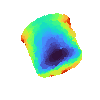

In [6]:
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]

position = torch.tensor([0.0, 0.1, 0.2], device=device)
quat = torch.tensor([1.0, 0.1, 0.2, 0.3],device=device)

camera_pose = jnp.eye(4)
view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose))),0,1).cuda()
raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([intrinsics.far, intrinsics.far, intrinsics.far]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=view_matrix @ proj_matrix,
    sh_degree=1,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)


def render(pose, in_color):
    means3D = apply_transform(vertices, pose)
    N = means3D.shape[0]
    means2D = torch.ones((N, 3),requires_grad=True, device=device)
    opacity = torch.rand((N, 1),requires_grad=True,device=device)
    scales = torch.tensor( 0.005 * torch.rand((N, 3)),requires_grad=True,device=device)
    rotations = torch.rand((N, 4),requires_grad=True,device=device)

    data = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = means3D[:,2:3],
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        in_color=in_color
    )
    return data

gt_pos = torch.tensor([0.0, 0.0, 0.5],device=device)
gt_quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
gt_pose = posevec_to_matrix(gt_pos, gt_quat)
gt_color, likelihood, radii =  render(gt_pose, torch.zeros((1, int(intrinsics.height), int(intrinsics.width)),device=device))
viz_gt = b.get_depth_image(gt_color.detach().cpu().numpy()[0,...])
viz_gt

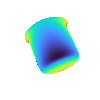

In [15]:
gt_pose_jnp =jnp.array(gt_pose.detach().cpu().numpy())
img = b.RENDERER.render(gt_pose_jnp[None,...], jnp.array([0]))
gt_color = torch.tensor(np.array(img[:,:,2]), device=device)

viz_gt = b.get_depth_image(gt_color.detach().cpu().numpy())
viz_gt

In [14]:
b.clear()
gt_color_jnp = jnp.array(gt_color.detach().cpu().numpy()[0,...])
b.show_cloud("1", b.unproject_depth_jit(gt_color_jnp,intrinsics).reshape(-1,3))
b.show_cloud("2", b.unproject_depth_jit(img[...,2],intrinsics).reshape(-1,3), color=b.RED)

In [51]:
b.show_trimesh("1",mesh)
b.set_pose("1", gt_pose_jnp)

/var/tmp/ipykernel_366687/1924790481.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(gt_pos ,device=device, requires_grad=True)
/var/tmp/ipykernel_366687/1924790481.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(gt_quat ,device=device, requires_grad=True)
  0%|          | 0/100 [00:00<?, ?it/s]/var/tmp/ipykernel_366687/3159514181.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.005 * torch.rand((N, 3)),requires_grad=True,device=device)
0.1059095710515976:   0%| 

0.10629859566688538:  11%|█         | 11/100 [00:00<00:00, 100.99it/s]

tensor(0.1299, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1869, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0974, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1433, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0997, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1252, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1082, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1169, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1153, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1063, device='cuda:0',

0.06752968579530716:  34%|███▍      | 34/100 [00:00<00:00, 98.12it/s] 

tensor(0.1044, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0989, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0896, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0861, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0757, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0806, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0735, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0737, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0737, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0652, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0666, device='cuda:0',

0.05946268141269684:  54%|█████▍    | 54/100 [00:00<00:00, 92.25it/s]

tensor(0.0724, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0702, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0722, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0632, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0685, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0712, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0595, device='cuda:0',

0.061479467898607254:  64%|██████▍   | 64/100 [00:00<00:00, 79.75it/s]

tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0709, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0747, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0615, device='cuda:0', grad_fn=<MeanBackward0>)


0.06789098680019379:  87%|████████▋ | 87/100 [00:01<00:00, 90.66it/s] 

tensor(0.0797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0705, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0655, device='cuda:0',

0.06520310044288635: 100%|██████████| 100/100 [00:01<00:00, 92.31it/s] 


tensor(0.0690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0698, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0652, device='cuda:0', grad_fn=<MeanBackward0>)


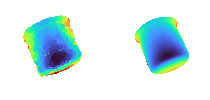

In [22]:
# pos = torch.tensor([0.0, 0.0, 1.9],device=device, requires_grad=True)
# quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)

pos = torch.tensor(gt_pos ,device=device, requires_grad=True)
quat =  torch.tensor(gt_quat ,device=device, requires_grad=True)

pose = posevec_to_matrix(pos, quat)
optimizer = torch.optim.Adam([
    {'params': [pos], 'lr': 0.01, "name": "pos"},
    {'params': [quat], 'lr': 0.01, "name": "quat"},
], lr=0.0, eps=1e-15)
b.clear()
b.show_pose("1", gt_pose.detach().cpu().numpy())
b.show_pose("2", pose.detach().cpu().numpy())

gt_color=gt_color.detach()
pbar = tqdm(range(100))
for _ in pbar:
    # print(pos,quat)
    pose = posevec_to_matrix(pos, quat)
    rendered_image, likelihood, radii =  render(pose, gt_color)
    loss = torch.abs(gt_color - rendered_image).mean()
    optimizer.zero_grad()
    loss.backward()
    print(loss)
    optimizer.step()
    # parameters_over_time.append((pos.detach().clone(),quat.detach().clone()))
    # losses_over_time.append(loss.item())
    pbar.set_description(f"{loss.item()}")

b.clear()
b.show_pose("1", gt_pose.detach().cpu().numpy())
b.show_pose("2", pose.detach().cpu().numpy())
viz = b.get_depth_image(rendered_image.detach().cpu().numpy()[0,...])
b.hstack_images([viz, viz_gt])

In [24]:
b.clear()
b.show_cloud("1", b.unproject_depth_jit(rendered_image[0,...].detach().cpu().numpy(),intrinsics).reshape(-1,3))
b.show_cloud("2", b.unproject_depth_jit(gt_color.detach().cpu().numpy(),intrinsics).reshape(-1,3), color=b.RED)

In [76]:
b.clear()
b.show_pose("1", gt_pose.detach().cpu().numpy())
b.show_pose("2", pose.detach().cpu().numpy())
# b.show_pose("2", b.unproject_depth_jit(img[...,2],intrinsics).reshape(-1,3), color=b.RED)

tensor(2.0167, device='cuda:0', grad_fn=<MaxBackward1>)


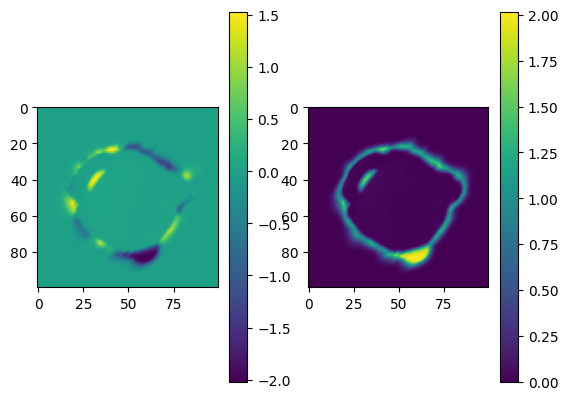

In [54]:
print(likelihood.max())
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.imshow((gt_color - rendered_image).detach().cpu().numpy()[0])
plt.colorbar()
ax = plt.subplot(1, 2, 2)
plt.imshow((likelihood).detach().cpu().numpy()[0])
plt.colorbar()

In [2]:
color.shape

torch.Size([3, 100, 100])

In [ ]:
T = 0
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2,2,1)
ax.set_title("Target")
gt_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img1 = ax.imshow(b.preprocess_for_viz(gt_image),cmap=b.cmap)
ax = fig.add_subplot(2,2,2)
parameters = parameters_over_time[T]
rendered_image = render(*parameters)
rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img2 = ax.imshow(b.preprocess_for_viz(rendered_image),cmap=b.cmap)
title = ax.set_title(f"Reconstruction")
ax = fig.add_subplot(2,1,2)
line = ax.plot(jnp.arange(T), losses_over_time[:T])
# ax.set_yscale("log")
ax.set_title("Pixelwise MSE Loss")
# ax.set_ylim(0.01, 1000.0)
ax.set_xlabel("Iteration")
ax.set_xlim(0,len(losses_over_time))
fig.tight_layout()

buffs = []
for T in tqdm(range(0,len(losses_over_time),3)):
    parameters = parameters_over_time[T]
    rendered_image = render(*parameters)
    rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
    img2.set_array(b.preprocess_for_viz(rendered_image))
    line[0].set_xdata(jnp.arange(T))
    line[0].set_ydata(losses_over_time[:T])
    fig.canvas.draw()
    buffs.append(b.pil_image_from_matplotlib(fig))
buffs[-1]

In [ ]:
b.make_gif_from_pil_images(buffs, "optimization.gif")